# < ResNet Ablation Study >

- 목차 -

□ Step1 데이터셋 준비하기   
□ Step2 ResNet 논문 살펴보기   
□ Step3 ResNet 생성 함수 정의   
□ Step4 모델 생성   
□ Step5 모델 훈련   
□ Step6 모델 학습 결과 시각화   
□ 정리 및 회고

### ■ Step1 데이터셋 준비하기

**1-1 필요한 라이브러리 import**

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import urllib3
urllib3.disable_warnings()

**1-2 Tensorflow가 활용할 GPU가 장착되어 있는지 확인**

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**1-3 'cats_vs_dogs' 데이터 로드**

In [4]:
tfds.disable_progress_bar() 

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


**1-4 Tensorflow 데이터셋 feature 정보 확인**

In [5]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


**1-5 데이터 개수 확인**

In [6]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


**1-6 feature 'label' class 개수와 이름 확인**

In [7]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

2
['cat', 'dog']


**1-7 train 데이터 샘플 확인**

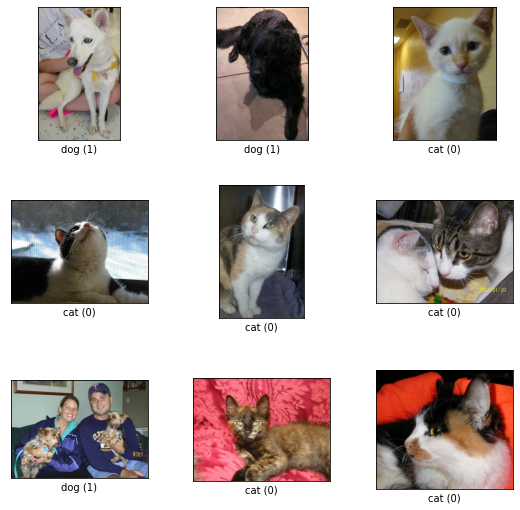

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

**1-7 test 데이터 샘플 확인**

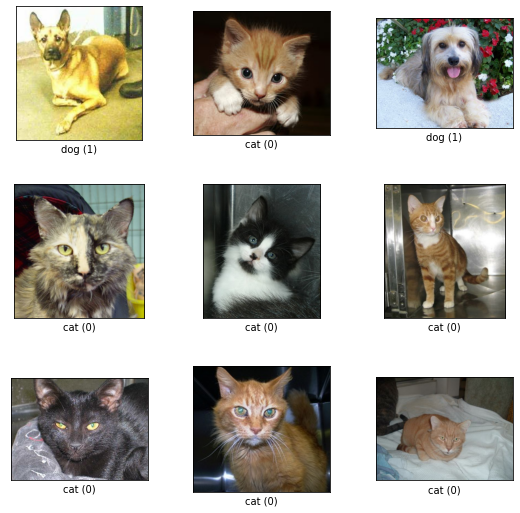

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

**1-8 데이터 정규화(Normalization) 함수 정의**

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### ■ Step2 ResNet 논문 살펴보기

**2-1 ResNet 논문 및 ResNet-34/ResNet-50 구조 확인**

- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)

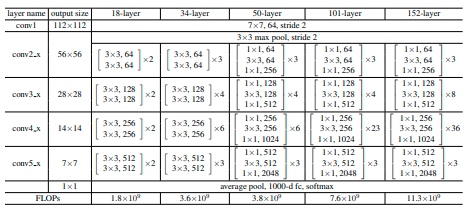




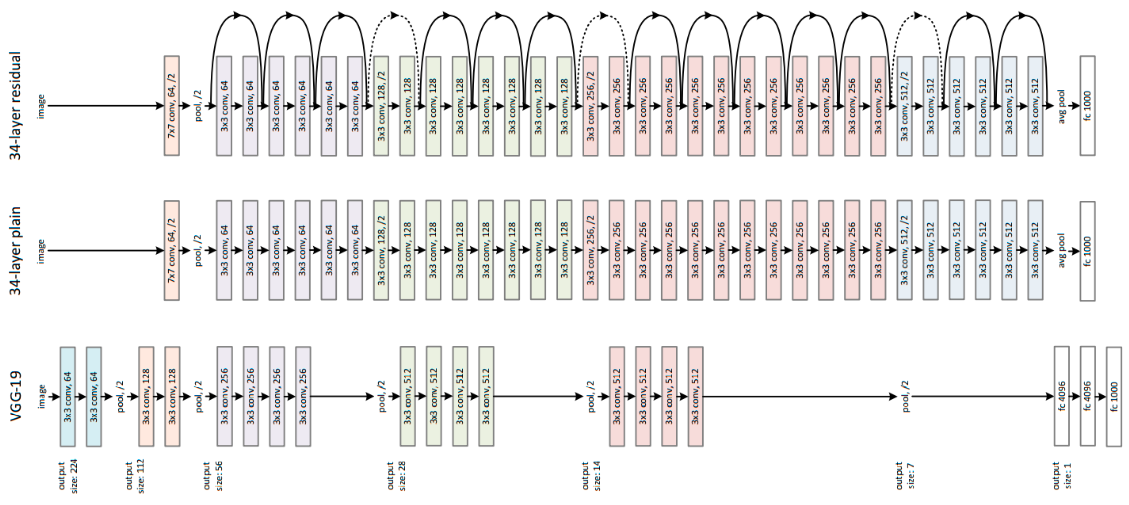

### ■ Step3 ResNet 생성 함수 정의

**3-1 conv_block 함수 정의**

- 논문 3.4 Implementation의 아래 문장을 살펴보면, Convolution layer + BatchNormalize layer + activation function(ReLU)가 하나의 쌍으로 묶여있음을 확인할 수 있다. 따라서 먼저 conv_block을 생성하는 함수를 만들고자 한다.


- The standard color augmentation in [21] is used. We adopt batchnormalization (BN) [16] right after each convolution and before activation, following [16].

In [15]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1,          
               activation='relu'):
    
    # convolutional layer    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)

    # Batch Normalization
    x = keras.layers.BatchNormalization()(x)

    # Relu Activation layer
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

**3-2 기본 블록 생성 build_resnet_or_plain_block 함수 정의**

In [16]:
def build_resnet_or_plain_block(input_shape, 
                                num_cnn=3, 
                                channel=64, 
                                block_num=0,
                                is_50 = True,
                                is_skip_connection = True):
   
    x = input_shape

    # ResNet-34(skip connection 존재)
    if not is_50 and is_skip_connection :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
            
    
    # ResNet-50(skip connection 존재)
    elif is_50 and is_skip_connection:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # Plain-34(skip connection 없음)
    elif not is_50 and not is_skip_connection :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
    
    # Plain-50(skip connection 없음)
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1)) 
 
    return x

**3-3 ResNet 모델 생성 build_resnet 함수 정의**

In [67]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 is_skip_connection = True,
                 activation='sigmoid',
                 name = 'ResNet-50'):
    
    assert len(channel_list) == len(num_cnn_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # ResNet 34와 ResNet 50의 공통된 앞 부분
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual 블록을 생성합니다.
    # ResNet 34의 Residual 블록
    if not is_50 and is_skip_connection:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)    
    
    # ResNet 50의 Residual 블록
    elif is_50 and is_skip_connection:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)
            

    # Plain 34의 블록
    elif not is_50 and not is_skip_connection:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)            
    # Plain 50의 블록
    else:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)      

    
    x = keras.layers.AveragePooling2D(padding='same')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(num_classes,
                           activation=activation,
                           kernel_initializer='he_normal',
                           name='fc1000')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name = name)
    
    return model

### ■ Step4 모델 생성

**4-1 ResNet-34 생성**

In [68]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, is_skip_connection = True, name = 'ResNet-34')
resnet_34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_978 (Conv2D)             (None, 16, 16, 64)   9472        input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_978 (BatchN (None, 16, 16, 64)   256         conv2d_978[0][0]                 
__________________________________________________________________________________________________
activation_905 (Activation)     (None, 16, 16, 64)   0           batch_normalization_978[0][0]    
__________________________________________________________________________________________

**4-2 ResNet-50 생성**

In [69]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True, is_skip_connection = True)
resnet_50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1014 (Conv2D)            (None, 16, 16, 64)   9472        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1014 (Batch (None, 16, 16, 64)   256         conv2d_1014[0][0]                
__________________________________________________________________________________________________
activation_938 (Activation)     (None, 16, 16, 64)   0           batch_normalization_1014[0][0]   
__________________________________________________________________________________________

**4-3 Plain-34 생성**

In [70]:
plain_34 = build_resnet(input_shape=(32,32,3), is_50=False, is_skip_connection = False, name = 'Plain-34')
plain_34.summary()

Model: "Plain-34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1067 (Conv2D)         (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_1067 (Ba (None, 16, 16, 64)        256       
_________________________________________________________________
activation_987 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1068 (Conv2D)         (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_1068 (Ba (None, 8, 8, 64)          256

**4-4 Plain-50 생성**

In [71]:
plain_50 = build_resnet(input_shape=(32,32,3), is_50 = True, is_skip_connection = False, name = 'Plain-50')
plain_50.summary()

Model: "Plain-50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1100 (Conv2D)         (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_1100 (Ba (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1020 (Activation) (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1101 (Conv2D)         (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_1101 (Ba (None, 8, 8, 64)          256

### ■ Step5 모델 훈련

**5-1 BATCH_SIZE, EPOCH 설정**

In [64]:
BATCH_SIZE = 32
EPOCH = 10

**5-2 데이터 정규화**

In [65]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

**5-3 ResNet-34 모델 학습**

In [74]:
resnet_34 = build_resnet(input_shape=(224,224,3),
                         num_classes=1,
                         is_50=False,
                         is_skip_connection = True,
                         activation='sigmoid',
                         name = 'ResNet_34')

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 309s 476ms/step - loss: 2.4639 - accuracy: 0.5718 - val_loss: 2.4535 - val_accuracy: 0.6089
Epoch 2/10
581/581 [==============================] - 268s 462ms/step - loss: 2.3794 - accuracy: 0.6430 - val_loss: 2.4899 - val_accuracy: 0.6325
Epoch 3/10
581/581 [==============================] - 283s 488ms/step - loss: 2.2996 - accuracy: 0.6977 - val_loss: 2.4290 - val_accuracy: 0.6427
Epoch 4/10
581/581 [==============================] - 268s 462ms/step - loss: 2.2611 - accuracy: 0.7185 - val_loss: 2.4921 - val_accuracy: 0.6263
Epoch 5/10
581/581 [==============================] - 268s 462ms/step - loss: 2.2154 - accuracy: 0.7531 - val_loss: 2.3214 - val_accuracy: 0.7112
Epoch 6/10
581/581 [==============================] - 268s 462ms/step - loss: 2.1376 - accuracy: 0.7952 - val_loss: 2.2606 - val_accuracy: 0.7398
Epoch 7/10
581/581 [==============================] - 269s 463ms/step - loss: 2.0678 - accuracy: 0.8308 - val_loss: 2.2540 -

**5-4 ResNet-50 모델 학습**

In [75]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         is_skip_connection=True,
                         activation='sigmoid',
                         name = 'ResNet_50')

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 270s 383ms/step - loss: 8.6705 - accuracy: 0.5106 - val_loss: 8.3461 - val_accuracy: 0.5426
Epoch 2/10
581/581 [==============================] - 176s 303ms/step - loss: 6.4534 - accuracy: 0.5446 - val_loss: 7.6140 - val_accuracy: 0.5606
Epoch 3/10
581/581 [==============================] - 176s 303ms/step - loss: 6.2726 - accuracy: 0.5897 - val_loss: 6.1554 - val_accuracy: 0.6589
Epoch 4/10
581/581 [==============================] - 176s 303ms/step - loss: 6.1552 - accuracy: 0.6255 - val_loss: 6.1142 - val_accuracy: 0.6327
Epoch 5/10
581/581 [==============================] - 176s 303ms/step - loss: 6.0590 - accuracy: 0.6503 - val_loss: 6.2182 - val_accuracy: 0.5543
Epoch 6/10
581/581 [==============================] - 176s 303ms/step - loss: 5.9906 - accuracy: 0.6815 - val_loss: 5.9281 - val_accuracy: 0.6222
Epoch 7/10
581/581 [==============================] - 176s 303ms/step - loss: 5.9316 - accuracy: 0.7193 - val_loss: 6.0485 -

**5-5 Plain-34 모델 학습**

In [76]:
plain_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         is_skip_connection=False,
                         activation='sigmoid', 
                         name='Plain_34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/10
581/581 [==============================] - 272s 443ms/step - loss: 2.2405 - accuracy: 0.5362 - val_loss: 2.2366 - val_accuracy: 0.5753
Epoch 2/10
581/581 [==============================] - 256s 442ms/step - loss: 2.2362 - accuracy: 0.5372 - val_loss: 2.4830 - val_accuracy: 0.4948
Epoch 3/10
581/581 [==============================] - 256s 441ms/step - loss: 2.2321 - accuracy: 0.5554 - val_loss: 2.2819 - val_accuracy: 0.5695
Epoch 4/10
581/581 [==============================] - 257s 442ms/step - loss: 2.2247 - accuracy: 0.5666 - val_loss: 2.2933 - val_accuracy: 0.5826
Epoch 5/10
581/581 [==============================] - 257s 442ms/step - loss: 2.2178 - accuracy: 0.5793 - val_loss: 2.2496 - val_accuracy: 0.5662
Epoch 6/10
581/581 [==============================] - 256s 441ms/step - loss: 2.2158 - accuracy: 0.5799 - val_loss: 2.2441 - val_accuracy: 0.5881
Epoch 7/10
581/581 [==============================] - 257s 442ms/step - loss: 2.1980 - accuracy: 0.6050 - val_loss: 2.1982 -

**5-6 Plain-50 모델 학습**

In [77]:
plain_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True, 
                         is_skip_connection=False,
                         activation='sigmoid', 
                         name='Plain_50')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 462s 720ms/step - loss: 5.2736 - accuracy: 0.5260 - val_loss: 5.3149 - val_accuracy: 0.5485
Epoch 2/10
581/581 [==============================] - 403s 693ms/step - loss: 5.2675 - accuracy: 0.5403 - val_loss: 5.2733 - val_accuracy: 0.5584
Epoch 3/10
581/581 [==============================] - 393s 676ms/step - loss: 5.2671 - accuracy: 0.5374 - val_loss: 5.4115 - val_accuracy: 0.5242
Epoch 4/10
581/581 [==============================] - 393s 676ms/step - loss: 5.2589 - accuracy: 0.5342 - val_loss: 5.5668 - val_accuracy: 0.5108
Epoch 5/10
581/581 [==============================] - 393s 677ms/step - loss: 5.2595 - accuracy: 0.5302 - val_loss: 5.2351 - val_accuracy: 0.5246
Epoch 6/10
581/581 [==============================] - 392s 675ms/step - loss: 5.2513 - accuracy: 0.5411 - val_loss: 5.2713 - val_accuracy: 0.5522
Epoch 7/10
581/581 [==============================] - 393s 676ms/step - loss: 5.2456 - accuracy: 0.5362 - val_loss: 5.2946 -

### ■ Step6 모델 학습 결과 시각화

**6-1 ResNet-34 vs Plain-34 학습 결과 비교**

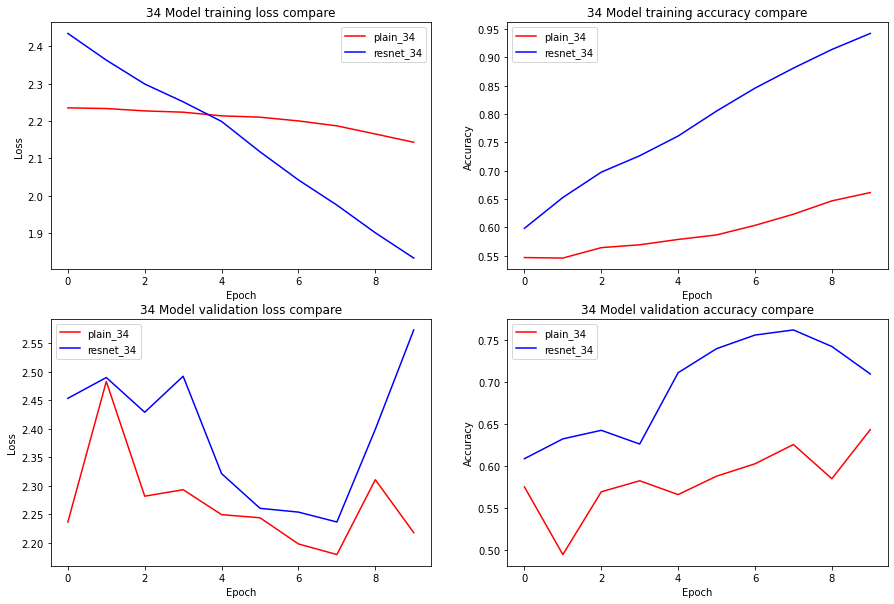

In [80]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
plt.plot(history_plain_34.history['loss'], 'r')
plt.plot(history_resnet_34.history['loss'], 'b')
plt.title('34 Model training loss compare')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'resnet_34'])

plt.subplot(2,2,2)
plt.plot(history_plain_34.history['accuracy'], 'r')
plt.plot(history_resnet_34.history['accuracy'], 'b')
plt.title('34 Model training accuracy compare')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'resnet_34'])

plt.subplot(2,2,3)
plt.plot(history_plain_34.history['val_loss'], 'r')
plt.plot(history_resnet_34.history['val_loss'], 'b')
plt.title('34 Model validation loss compare')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'resnet_34'])

plt.subplot(2,2,4)
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.title('34 Model validation accuracy compare')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'resnet_34'])
plt.show()

**6-2 ResNet-50 vs Plain-50 학습 결과 비교**

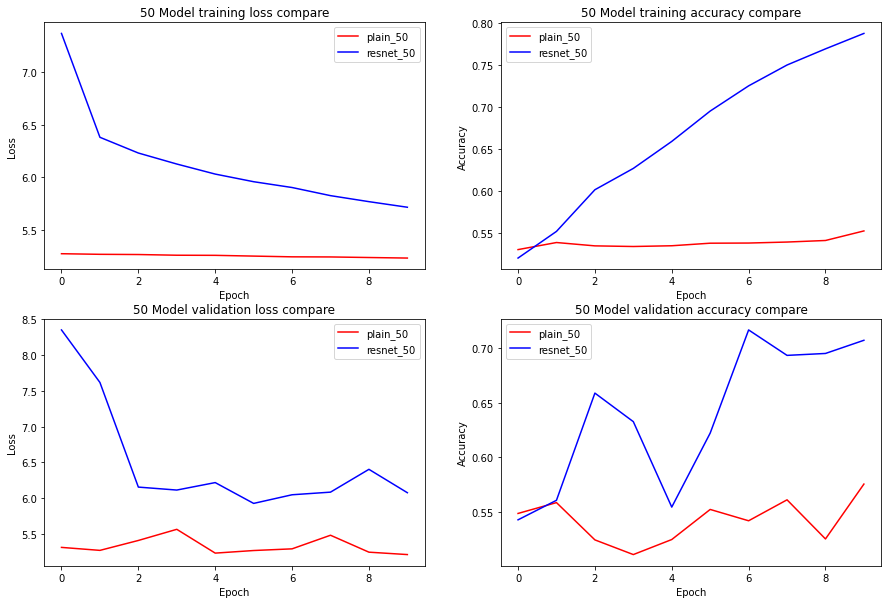

In [81]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
plt.plot(history_plain_50.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.title('50 Model training loss compare')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'resnet_50'])

plt.subplot(2,2,2)
plt.plot(history_plain_50.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.title('50 Model training accuracy compare')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'resnet_50'])

plt.subplot(2,2,3)
plt.plot(history_plain_50.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.title('50 Model validation loss compare')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'resnet_50'])

plt.subplot(2,2,4)
plt.plot(history_plain_50.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('50 Model validation accuracy compare')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'resnet_50'])
plt.show()

### ■ 정리 및 회고

**1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?**

- 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

- 노드 상에 예시로 제시된 ResNet-34의 params를 확인해보면 아래와 같다.

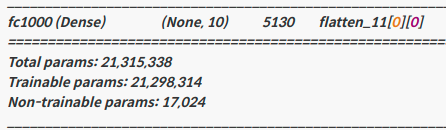

- 아래 사진은 구현한 ResNet-34의 params인데, 위 사진과 똑같음을 확인 할 수 있다.

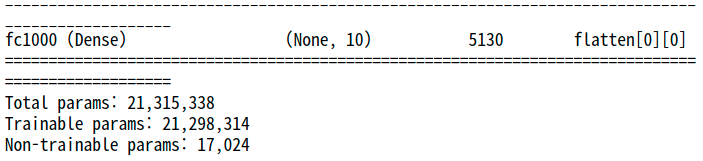

**2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?**

- cats_vs_dogs 데이터셋으로 10 epoch 학습하였는데, 시각화 결과를 보면 4가지 모델 모두 안정적으로 loss 감소가 진행된 것을 확인할 수 있다. (ResNet-34의 val_loss의 경우 감소하다가 증가하는 모양을 보이긴 한다..)



**3. Ablation Study 결과가 바른 포맷으로 제출되었는가?**

- ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표를 작성하면 아래와 같다.

|epoch10|ResNet-34|Plain-34|ResNet-50|Plain-50|
|---|---|---|---|---|
|validation accuracy|0.7097|0.6435|0.7073|0.5754|




**4. 소감**

- 처음으로 딥러닝 논문을 천천히 읽어보며, 한 줄 한 줄 모델을 구현해보니 힘들고 어려웠지만, 여러 번의 시행착오 끝에 ResNet을 구현할 수 있어서 뿌듯하다. 이번에 구현해봤다고 완벽히 내것이 된 것은 아닐 것이다. 여러번 다시 반복하고 다른 논문의 모델도 구현해볼 수 있도록 노력해야겠다.